In [ ]:
class CVRP:
    def __init__(self, num_customers, num_vehicles, vehicle_capacity, customer_demands, distances, depot, shelter):
        self.num_customers = num_customers
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_demands = customer_demands
        self.distances = distances
        self.depot = depot
        self.shelter = shelter
        self.num_locations = num_customers + 2  # Including depot and shelter
        self.y = np.zeros((self.num_locations, self.num_vehicles))  # y[i][k] -> if vehicle k visits location i
        self.x = np.zeros((self.num_locations, self.num_locations, self.num_vehicles))  # x[i][j][k] -> if vehicle k moves from i to j
        self.q = np.zeros((self.num_locations, self.num_vehicles))  # q[i][k] -> cargo at location i for vehicle k

    def check_capacity(self, i, k, j):
        # Checks if the vehicle can pick up more cargo at location i and move to location j
        if self.q[i][k] + self.customer_demands[j] > self.vehicle_capacity:
            return False
        return True

    def objective_function(self):
        # Objective is to minimize the total distance
        total_distance = 0
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                for j in range(self.num_locations):
                    total_distance += self.distances[i][j] * self.x[i][j][k]
        return total_distance

    def apply_constraints(self):
        # 3.2: Each customer must be visited exactly once by one vehicle
        for i in range(1, self.num_locations - 1):  # Exclude depot and shelter
            if np.sum(self.y[i]) != 1:
                return False

        # 3.3: If vehicle k visits i, then it must move to j
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                if np.sum(self.x[i, :, k]) != self.y[i, k]:  # If x[i,j,k] is 1, y[i,k] must be 1
                    return False

        # 3.4: If vehicle k moves from i to j, y[j,k] must be 1
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                if np.sum(self.x[:, i, k]) != self.y[i, k]:  # If x[i,j,k] is 1, y[j,k] must be 1
                    return False

        # 3.5: Ensure cargo does not exceed vehicle capacity
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                if self.q[i][k] + self.customer_demands[i] > self.vehicle_capacity:
                    return False

        # 3.6: Ensure vehicle cargo at destination does not exceed capacity
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                for j in range(self.num_locations):
                    if self.q[i][k] + self.customer_demands[j] > self.vehicle_capacity:
                        return False

        # 3.7: Update cargo at location j after visiting i
        for k in range(self.num_vehicles):
            for i in range(self.num_locations):
                for j in range(self.num_locations):
                    if self.x[i, j, k] == 1:  # If vehicle k moves from i to j
                        self.q[j][k] = self.q[i][k] + self.customer_demands[j]  # Update cargo at j after moving from i to j
                    if self.q[j][k] > self.vehicle_capacity:  # Check capacity constraint
                        return False

        # 3.8: Define set S as the visited locations
        S = set()
        for k in range(self.num_vehicles):
            for i in range(1, self.num_locations - 1):
                if self.y[i, k] == 1:
                    S.add(i)
        # Check if S includes all necessary points
        if len(S) != self.num_customers:  # Should visit all customers, excluding depot and shelter
            return False

        # 3.9: Vehicle must go to shelter if its capacity is exceeded
        for k in range(self.num_vehicles):
            for j in range(1, self.num_locations - 1):  # Exclude depot and shelter
                if self.q[j, k] > self.vehicle_capacity:
                    self.x[j, self.shelter, k] = 1  # Force vehicle k to go to shelter

        # 3.10: Vehicle must go to shelter if it doesn't visit any other location
        for k in range(self.num_vehicles):
            for j in range(1, self.num_locations - 1):  # Exclude depot and shelter
                if self.y[j, k] == 0:
                    self.x[j, self.shelter, k] = 1  # Force vehicle k to go to shelter if j is not visited

        # 3.11: Vehicle must depart from depot and visit another location
        for k in range(self.num_vehicles):
            if np.sum(self.x[self.depot, :, k]) == 0:  # Vehicle must move away from depot
                return False

        # 3.12: Vehicle must visit shelter exactly once
        for k in range(self.num_vehicles):
            if np.sum(self.x[:, self.shelter, k]) != 1:
                return False

        # 3.13: Vehicle must return to depot after visiting shelter
        for k in range(self.num_vehicles):
            if self.x[self.shelter, self.depot, k] != 1:
                return False

        # 3.14: Total cargo at shelter cannot exceed shelter's capacity
        total_cargo_at_shelter = 0
        for k in range(self.num_vehicles):
            for i in range(1, self.num_locations - 1):  # Exclude depot and shelter
                if self.x[i, self.shelter, k] == 1:
                    total_cargo_at_shelter += self.q[i, k]
        if total_cargo_at_shelter > self.vehicle_capacity:
            return False

        return True

In [ ]:
import numpy as np
import random

class MMAS_CVRP:
    def __init__(self, num_customers, num_vehicles, vehicle_capacity, customer_demands, distance_matrix, depot, shelter):
        # Initialize parameters from the problem
        self.num_customers = num_customers
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_demands = customer_demands
        self.distance_matrix = distance_matrix
        self.depot = depot  # Ensure depot is passed correctly
        self.shelter = shelter  # Ensure shelter is passed correctly
        self.num_locations = num_customers + 2  # Including depot and shelter
        self.alpha = 1  # Influence of pheromone
        self.beta = 2  # Influence of distance
        self.rho = 0.5  # Pheromone evaporation rate
        self.tau_min = 0.001  # Minimum pheromone level
        self.tau_max = 1  # Maximum pheromone level
        self.pheromone = np.ones((self.num_locations, self.num_locations)) * 0.1  # Initial pheromone levels
        self.best_solution = None
        self.best_distance = float('inf')

    def select_next_location(self, current_location, visited, cargo):
        # Initialize list for probabilities and valid locations
        probabilities = []
        valid_locations = []

        # Iterate over all possible locations (exclude depot and shelter)
        for j in range(1, self.num_locations - 1):  # Exclude depot (0) and shelter (6)
            if not visited[j] and self.check_capacity(cargo, j):  # Ensure capacity is not exceeded
                pheromone_level = self.pheromone[current_location][j] ** self.alpha
                distance = self.distance_matrix[current_location][j] ** self.beta
                desirability = pheromone_level / distance
                probabilities.append(desirability)
                valid_locations.append(j)

        # If no valid locations (all locations are visited), go to shelter
        if not valid_locations:
            return 6  # Go to shelter if no valid locations

        # Normalize the probabilities so that they sum to 1
        total_prob = sum(probabilities)
        probabilities = [p / total_prob for p in probabilities]

        # Select next location based on calculated probabilities
        return np.random.choice(valid_locations, p=probabilities)

    def check_capacity(self, cargo, next_location):
        # Check if adding this location's demand will exceed the vehicle's capacity
        if cargo + self.customer_demands[next_location] > self.vehicle_capacity:
            return False
        return True

    def construct_solution(self):
        # Create a solution for each vehicle
        visited = [False] * self.num_locations
        paths = {k: [] for k in range(self.num_vehicles)}  # Store the paths for each vehicle
        cargo = {k: 0 for k in range(self.num_vehicles)}  # Track cargo for each vehicle

        for k in range(self.num_vehicles):
            current_location = self.depot  # Start from depot
            visited[current_location] = True
            while True:
                next_location = self.select_next_location(current_location, visited, cargo[k])
                if next_location == 6:  # If vehicle has to go to shelter
                    paths[k].append((current_location, 6))
                    break
                paths[k].append((current_location, next_location))
                visited[next_location] = True
                cargo[k] += self.customer_demands[next_location]
                current_location = next_location
        return paths

    def update_pheromones(self, paths, distance):
        # Update the pheromone levels on the paths
        for k in range(self.num_vehicles):
            for i, j in paths[k]:
                self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + self.rho * (1 / distance)

    def evaluate_solution(self, paths):
        # Calculate the total distance for a given solution
        total_distance = 0
        for k in range(self.num_vehicles):
            for i, j in paths[k]:
                total_distance += self.distance_matrix[i][j]
        return total_distance

    def run(self, num_iterations):
        # Initialize best solution
        best_solution = None
        best_distance = float('inf')

        for _ in range(num_iterations):
            # Construct a solution using ants
            solution = self.construct_solution()
            distance = self.evaluate_solution(solution)

            # Update best solution if found a better one
            if distance < best_distance:
                best_solution = solution
                best_distance = distance

            # Update pheromone levels based on the solution
            self.update_pheromones(solution, distance)

        return best_solution, best_distance

    def apply_constraints(self, solution):
        # Check if the solution respects all the constraints (including capacity and shelter limits)
        total_cargo_at_shelter = 0
        for route in solution:
            for i in range(len(route) - 1):
                if route[i + 1] == 6:  # If vehicle goes to shelter
                    total_cargo_at_shelter += sum(self.customer_demands[route[j]] for j in range(len(route) - 1))

        if total_cargo_at_shelter > self.shelter_capacity:
            return False

        # Additional checks can be added for customer visit constraints and other rules
        return True

# Define the problem parameters
distance_matrix = np.array([
    [0.00, 6.49, 2.61, 3.76, 5.54, 7.29, 8.15],
    [6.49, 0.00, 7.21, 4.08, 6.70, 4.59, 6.64],
    [2.61, 7.21, 0.00, 5.17, 3.80, 3.73, 6.04],
    [3.76, 4.08, 5.17, 0.00, 4.78, 5.35, 6.61],
    [5.54, 6.70, 3.80, 4.78, 0.00, 6.02, 5.79],
    [7.29, 4.59, 3.73, 5.35, 6.02, 0.00, 5.98],
    [8.15, 6.64, 6.04, 6.61, 5.79, 5.98, 0.00]
])

# Demand for the customers (0 - Depot, 1 - Pemukiman, 2 - Perkotaan, 3 - Dataran Rendah, 4 - Pedesaan, 5 - Terminal, 6 - Shelter)
customer_demands = [0, 60, 70, 40, 20, 10, 0]

# Initialize MMAS_CVRP
depot = 0  # Depot is at location 0
shelter = 6  # Shelter is at location 6
num_customers = 5  # There are 5 customer locations
num_vehicles = 2  # Two vehicles
vehicle_capacity = 150  # Vehicle capacity is 110 people

mmas = MMAS_CVRP(num_customers=num_customers, num_vehicles=num_vehicles, vehicle_capacity=vehicle_capacity,
                 customer_demands=customer_demands, distance_matrix=distance_matrix, depot=depot, shelter=shelter)

# Run the algorithm for 100 iterations
best_solution, best_distance = mmas.run(num_iterations=100)

# Print the best solution and distance found
print(f"Best Solution: {best_solution}")
print(f"Best Distance: {best_distance}")


Best Solution: {0: [(0, 2), (2, 5), (5, 1), (1, 6)], 1: [(0, 3), (3, 4), (4, 6)]}
Best Distance: 31.9


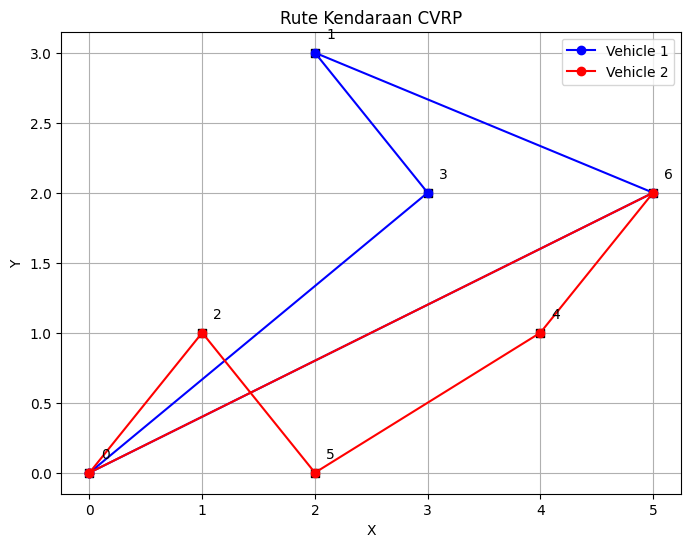

Best Solution: {0: [(0, 3), (3, 1), (1, 6), (6, 0)], 1: [(0, 2), (2, 5), (5, 4), (4, 6), (6, 0)]}
Best Distance: 48.93


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class MMAS_CVRP:
    def __init__(self, num_customers, num_vehicles, vehicle_capacity, customer_demands, distance_matrix, depot, shelter):
        # Initialize parameters from the problem
        self.num_customers = num_customers
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_demands = customer_demands
        self.distance_matrix = distance_matrix
        self.depot = depot  # Ensure depot is passed correctly
        self.shelter = shelter  # Ensure shelter is passed correctly
        self.num_locations = num_customers + 2  # Including depot and shelter
        self.alpha = 1  # Influence of pheromone
        self.beta = 2  # Influence of distance
        self.rho = 0.5  # Pheromone evaporation rate
        self.tau_min = 0.001  # Minimum pheromone level
        self.tau_max = 1  # Maximum pheromone level
        self.pheromone = np.ones((self.num_locations, self.num_locations)) * 0.1  # Initial pheromone levels
        self.best_solution = None
        self.best_distance = float('inf')

    def select_next_location(self, current_location, visited, cargo):
        # Initialize list for probabilities and valid locations
        probabilities = []
        valid_locations = []

        # Iterate over all possible locations (exclude depot and shelter)
        for j in range(1, self.num_locations - 1):  # Exclude depot (0) and shelter (6)
            if not visited[j] and self.check_capacity(cargo, j):  # Ensure capacity is not exceeded
                pheromone_level = self.pheromone[current_location][j] ** self.alpha
                distance = self.distance_matrix[current_location][j] ** self.beta
                desirability = pheromone_level / distance
                probabilities.append(desirability)
                valid_locations.append(j)

        # If no valid locations (all locations are visited), go to shelter
        if not valid_locations:
            return 6  # Go to shelter if no valid locations

        # Normalize the probabilities so that they sum to 1
        total_prob = sum(probabilities)
        probabilities = [p / total_prob for p in probabilities]

        # Select next location based on calculated probabilities
        return np.random.choice(valid_locations, p=probabilities)

    def check_capacity(self, cargo, next_location):
        # Check if adding this location's demand will exceed the vehicle's capacity
        if cargo + self.customer_demands[next_location] > self.vehicle_capacity:
            return False
        return True

    def construct_solution(self):
        # Create a solution for each vehicle
        visited = [False] * self.num_locations
        paths = {k: [] for k in range(self.num_vehicles)}  # Store the paths for each vehicle
        cargo = {k: 0 for k in range(self.num_vehicles)}  # Track cargo for each vehicle

        for k in range(self.num_vehicles):
            current_location = self.depot  # Start from depot
            visited[current_location] = True
            while True:
                next_location = self.select_next_location(current_location, visited, cargo[k])
                if next_location == 6:  # If vehicle has to go to shelter
                    paths[k].append((current_location, 6))
                    # After shelter, return to depot
                    paths[k].append((6, self.depot))
                    break
                paths[k].append((current_location, next_location))
                visited[next_location] = True
                cargo[k] += self.customer_demands[next_location]
                current_location = next_location
        return paths

    def update_pheromones(self, paths, distance):
        # Update the pheromone levels on the paths
        for k in range(self.num_vehicles):
            for i, j in paths[k]:
                self.pheromone[i][j] = (1 - self.rho) * self.pheromone[i][j] + self.rho * (1 / distance)

    def evaluate_solution(self, paths):
        # Calculate the total distance for a given solution
        total_distance = 0
        for k in range(self.num_vehicles):
            for i, j in paths[k]:
                total_distance += self.distance_matrix[i][j]
        return total_distance

    def run(self, num_iterations):
        # Initialize best solution
        best_solution = None
        best_distance = float('inf')

        for _ in range(num_iterations):
            # Construct a solution using ants
            solution = self.construct_solution()
            distance = self.evaluate_solution(solution)

            # Update best solution if found a better one
            if distance < best_distance:
                best_solution = solution
                best_distance = distance

            # Update pheromone levels based on the solution
            self.update_pheromones(solution, distance)

        return best_solution, best_distance

# Define the problem parameters
distance_matrix = np.array([
    [0.00, 6.49, 2.61, 3.76, 5.54, 7.29, 8.15],
    [6.49, 0.00, 7.21, 4.08, 6.70, 4.59, 6.64],
    [2.61, 7.21, 0.00, 5.17, 3.80, 3.73, 6.04],
    [3.76, 4.08, 5.17, 0.00, 4.78, 5.35, 6.61],
    [5.54, 6.70, 3.80, 4.78, 0.00, 6.02, 5.79],
    [7.29, 4.59, 3.73, 5.35, 6.02, 0.00, 5.98],
    [8.15, 6.64, 6.04, 6.61, 5.79, 5.98, 0.00]
])

# Demand for the customers (0 - Depot, 1 - Pemukiman, 2 - Perkotaan, 3 - Dataran Rendah, 4 - Pedesaan, 5 - Terminal, 6 - Shelter)
customer_demands = [0, 60, 40, 70, 20, 10, 0]

# Initialize MMAS_CVRP
depot = 0  # Depot is at location 0
shelter = 6  # Shelter is at location 6
num_customers = 5  # There are 5 customer locations
num_vehicles = 2  # Two vehicles
vehicle_capacity = 130  # Vehicle capacity is 130 people

locations = {
    0: (0, 0),  # Depot
    1: (2, 3),  # Pemukiman
    2: (1, 1),  # Perkotaan
    3: (3, 2),  # Dataran Rendah
    4: (4, 1),  # Pedesaan
    5: (2, 0),  # Terminal
    6: (5, 2)   # Shelter
    3: (3, 2),  # Dataran Rendah
    4: (4, 1),  # Pedesaan
    5: (2, 0),  # Terminal
    6: (5, 2)   # Shelter
}

# Warna untuk setiap kendaraan
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Tambahkan lebih banyak warna jika diperlukan

# Plot rute untuk setiap kendaraan
plt.figure(figsize=(8, 6))
for k, route in best_solution.items():
    x = [locations[node[0]][0] for node in route]
    y = [locations[node[0]][1] for node in route]
    x.append(locations[route[-1][1]][0])  # Tambahkan koordinat tujuan terakhir
    y.append(locations[route[-1][1]][1])
    plt.plot(x, y, marker='o', color=colors[k], label=f'Vehicle {k + 1}')

# Plot lokasi
for location, coords in locations.items():
    plt.scatter(coords[0], coords[1], marker='s', color='black')
    plt.text(coords[0] + 0.1, coords[1] + 0.1, str(location))

plt.title('Rute Kendaraan CVRP')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

mmas = MMAS_CVRP(num_customers=num_customers, num_vehicles=num_vehicles, vehicle_capacity=vehicle_capacity,
                 customer_demands=customer_demands, distance_matrix=distance_matrix, depot=depot, shelter=shelter)

# Run the algorithm for 100 iterations
best_solution, best_distance = mmas.run(num_iterations=100)

# Print the best solution and distance found
print(f"Best Solution: {best_solution}")
print(f"Best Distance: {round(best_distance, 2)}")
